In [1]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_auc_score, classification_report, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', 999)
random_state = 10


In [2]:
project_path = 'C:\\Users\\a\\PycharmProjects\\interview'
data_path = os.path.join(project_path, 'data', 'bank-additional-full.csv')
print(data_path)

C:\Users\a\PycharmProjects\interview\data\bank-additional-full.csv


In [3]:
df = pd.read_csv(data_path, sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.shape

(41188, 21)

# Check for duplicate records

In [5]:
df = df.drop_duplicates(ignore_index=True)
df.shape

(41176, 21)

# Drop the duration column as mentioned in dataset

In [6]:
df = df.drop("duration", axis=1)
df.shape

(41176, 20)

# Split data into features and labels

In [7]:
data = df.drop('y', axis=1)
label = df['y']

# Train Test Split

In [8]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=random_state)
(train_indices, test_indices), (_, _) = sss.split(data, label)
X_train, y_train = data.iloc[data.index[train_indices]].reset_index(drop=True), label[train_indices]
X_test, y_test = data.iloc[data.index[test_indices]].reset_index(drop=True), label[test_indices]


In [9]:
print(f'training data  size {X_train.shape}')
print(f'testing data  size {X_test.shape}')


training data  size (37058, 19)
testing data  size (4118, 19)


In [10]:
class_weight = pd.DataFrame({'y': y_train})['y'].value_counts(normalize=True).to_dict()
print("classes distribution")
print(f"\ttraining: {class_weight}")
print(f"\ttesting: {pd.DataFrame({'y': y_test})['y'].value_counts(normalize=True).to_dict()}")


classes distribution
	training: {'no': 0.8873387662582978, 'yes': 0.1126612337417022}
	testing: {'no': 0.8873239436619719, 'yes': 0.11267605633802817}


In [11]:
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,50,admin.,divorced,university.degree,no,yes,no,telephone,nov,mon,2,999,1,failure,-0.1,93.200,-42.0,4.191,5195.8
1,58,retired,married,basic.4y,no,yes,no,cellular,aug,fri,3,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,36,admin.,single,high.school,no,yes,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
3,37,admin.,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,38,services,divorced,high.school,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


# Data Processing

### Ordinal encoding

In [12]:
ordinal_mapping_dict = {
    "education": {"unknown": 0, "illiterate": 1, "basic.4y": 2, "basic.6y": 3, "basic.9y": 4, "high.school": 5,
                  "professional.course": 6, "university.degree": 7},
    "contact": {"cellular": 0, "telephone": 1, },
}


In [13]:
for col, values in ordinal_mapping_dict.items():
    X_train[col] = X_train[col].replace(values)
    X_test[col] = X_test[col].replace(values)
    

### Onehot encoding

In [14]:
cat_col = X_train.dtypes[X_train.dtypes=='object'].index

one_hot_encoder=OneHotEncoder()
X_train_transformed = one_hot_encoder.fit_transform(X_train[cat_col])
column_names = list(itertools.chain(*[[f'{col}_{i}' for i in cat] for col, cat in zip(cat_col, one_hot_encoder.categories_)]))


X_train = pd.concat([X_train, pd.DataFrame(X_train_transformed.toarray(), columns=column_names)], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(one_hot_encoder.transform(X_test[cat_col]).toarray(), columns=column_names)], axis=1)

X_train = X_train.drop(cat_col, axis=1)
X_test = X_test.drop(cat_col, axis=1)


### Replacing Outlier

In [15]:
pdays_mapping = {999: 0}
X_train['pdays'] = X_train['pdays'].replace(pdays_mapping)
X_test['pdays'] = X_test['pdays'].replace(pdays_mapping)


### label encoder

In [16]:
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
y_test = label_enc.transform(y_test)


# Cross valdiation set generator

In [17]:
cv_generator = StratifiedShuffleSplit(n_splits=5, test_size=0.01, random_state=random_state)

# Plot the Area Under ROC Curve 

In [18]:
def plot_metrics(classifier, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    fig = plt.figure(figsize=(8, 7)).gca()
    plot_roc_curve(classifier, X_train, y_train, ax=fig, name='train')
    plot_roc_curve(classifier, X_test, y_test, ax=fig, name='test')


# Logistic Regresstion

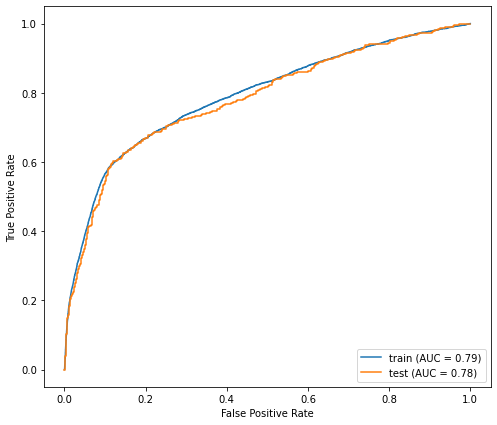

In [19]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)

lr.fit(X_train, y_train)

plot_metrics(lr)


### Cross Valdiation - LR

In [20]:
lr_cv = LogisticRegression(class_weight ='balanced', max_iter=1000)

cv_lr = cross_validate(lr_cv, 
                    X_train, 
                    y_train, 
                    cv=cv_generator, 
                    scoring={'roc_auc':'roc_auc', "f1":'f1'},
                    return_train_score=True,
                    return_estimator=True
                   )


print("roc_auc")
print(f"\ttrainin: {np.mean(cv_lr['train_roc_auc'])}")
print(f"\tvalidation: {np.mean(cv_lr['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test, es.predict_proba(X_test)[:,1]) for es in cv_lr['estimator']])}")

roc_auc
	trainin: 0.7911211204830788
	validation: 0.798060500796063
	test: 0.7831819876186701


# Random Forest

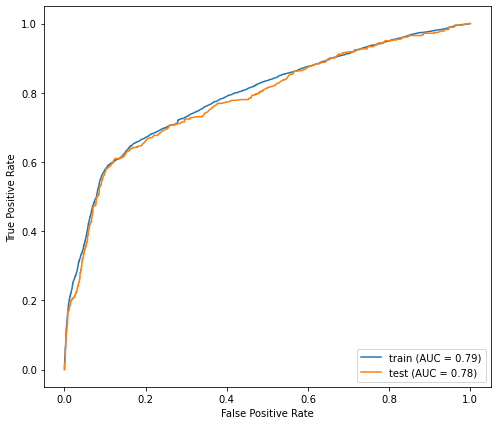

In [21]:
rfc = RandomForestClassifier(class_weight='balanced_subsample',
                             max_depth=3,
                             random_state=random_state)
rfc.fit(X_train, y_train)

plot_metrics(rfc)


<BarContainer object of 54 artists>

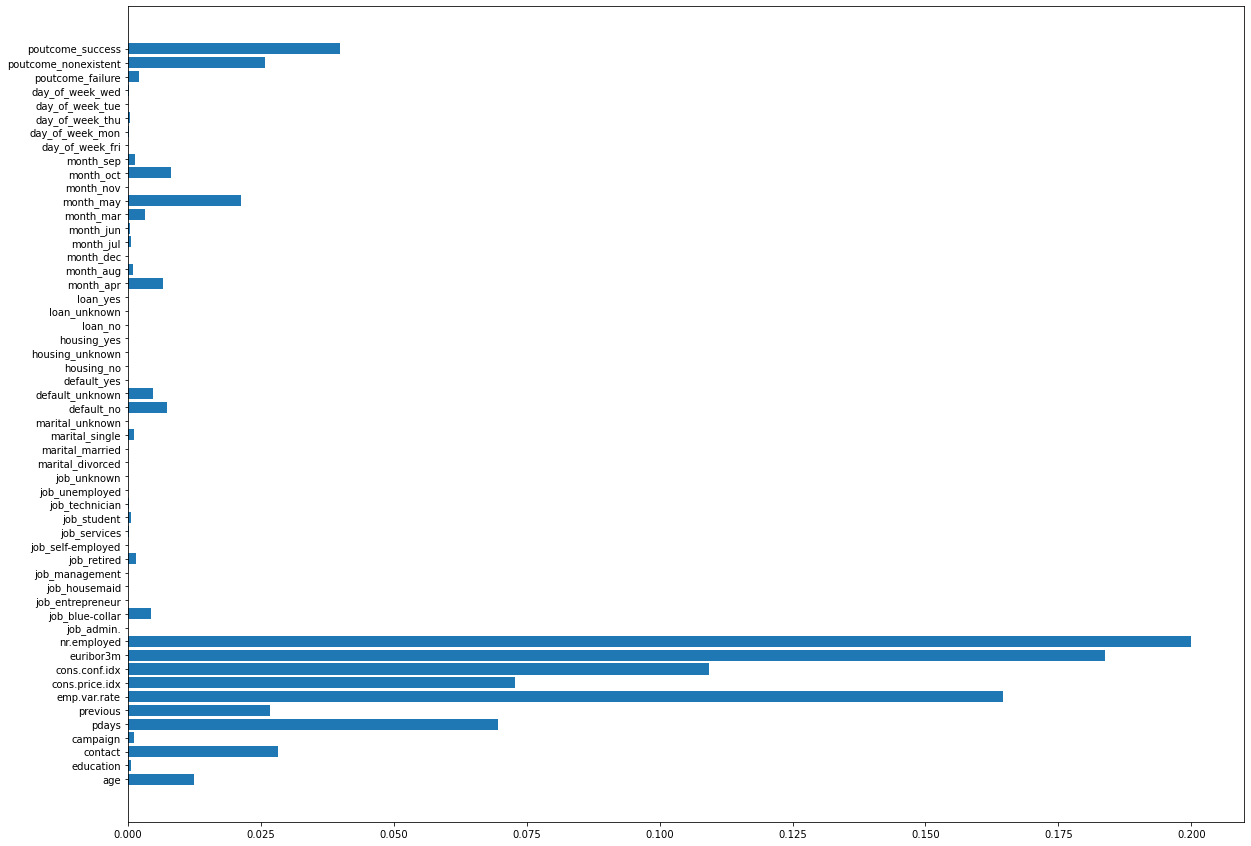

In [22]:
plt.figure(figsize=(20, 15))
plt.barh(X_train.columns, rfc.feature_importances_)


### Cross Validation - RFC

In [23]:
rfc_cv = RandomForestClassifier(class_weight='balanced_subsample',
                                max_depth=10,
                                random_state=random_state,
                               criterion="entropy")

cv_rfc = cross_validate(rfc_cv,
                    X_train,
                    y_train,
                    cv=cv_generator,
                    scoring={'roc_auc': 'roc_auc', "f1": 'f1'},
                    return_train_score=True,
                    return_estimator=True
                    )

print("roc_auc")
print(f"\ttrainin: {np.mean(cv_rfc['train_roc_auc'])}")
print(f"\tvalidation: {np.mean(cv_rfc['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test, es.predict_proba(X_test)[:,1]) for es in cv_rfc['estimator']])}")


roc_auc
	trainin: 0.8507072148179382
	validation: 0.8029743812418586
	test: 0.8011470070588681


### Grid Search - RFC

Best params: {'max_depth': 10}


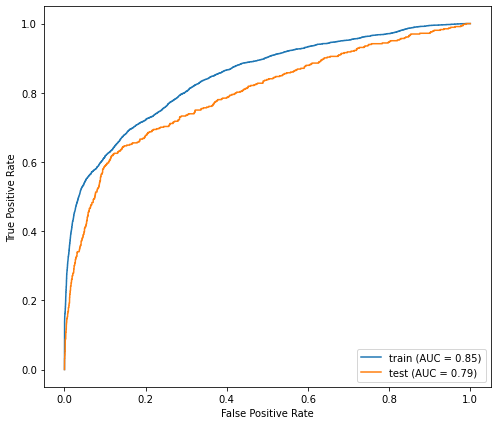

In [24]:
param_grid = {
    'max_depth': [2,3,4,5,6,7,8,9,10, 11, 12],
}

rfc_cv = RandomForestClassifier(n_estimators=100,
                                    max_features='auto', 
                                    random_state=random_state)

rfc_search = GridSearchCV(rfc_cv, 
                      param_grid, 
                      cv=cv_generator,
                      scoring='roc_auc',
                      return_train_score=True)

rfc_search.fit(X_train, y_train)

print(f"Best params: {rfc_search.best_params_}")
plot_metrics(rfc_search)

Text(0, 0.5, 'AUC')

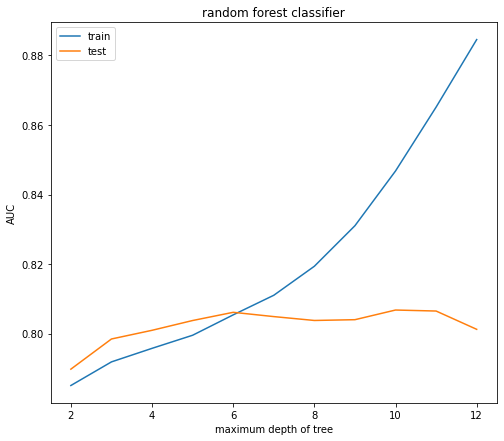

In [25]:
pd.DataFrame({"train":rfc_search.cv_results_["mean_train_score"], 
              "test":rfc_search.cv_results_["mean_test_score"]}, 
             index=[list(x.values())[0] for x in rfc_search.cv_results_["params"]]).plot(figsize=(8, 7))
plt.title("random forest classifier")
plt.xlabel("maximum depth of tree")
plt.ylabel("AUC")
# plt.savefig("overfitting.jpg", bbox_inches='tight', dpi=150)

# Gradient Boosting Classifier

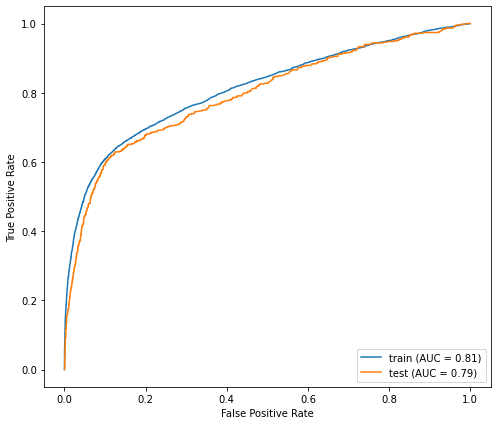

In [26]:
gbc = GradientBoostingClassifier(n_estimators=100,
                                 max_depth=5,
                                 random_state=random_state,
                                 n_iter_no_change=10,
                                 subsample=0.5)

gbc.fit(X_train, y_train)

plot_metrics(gbc)


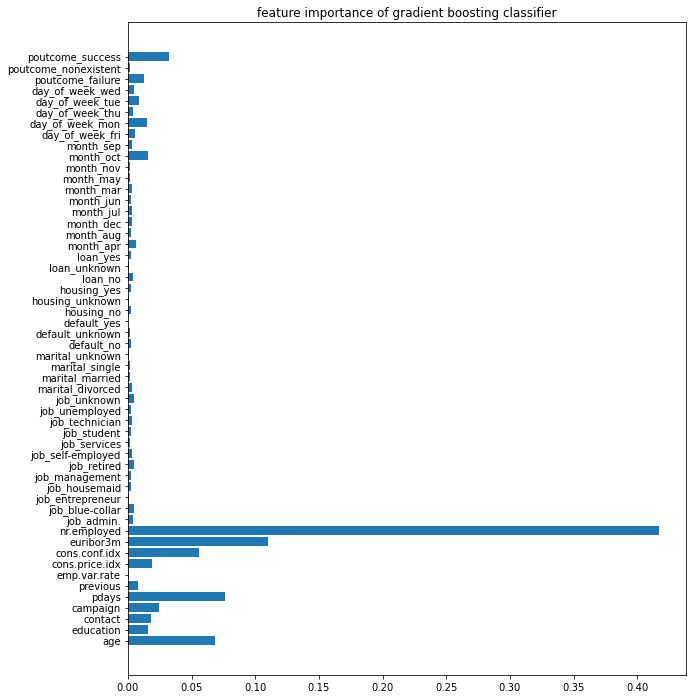

In [27]:
plt.figure(figsize=(10, 12))
plt.barh(X_train.columns, gbc.feature_importances_)
plt.title(f'feature importance of gradient boosting classifier')
plt.savefig("gbc_feature.jpg", bbox_inches='tight', dpi=150)

#### Cross Validation - GBC

In [28]:
gbc_cv = GradientBoostingClassifier(n_estimators=100, max_depth=5, 
                                 random_state=random_state, n_iter_no_change=10, 
                                 subsample=0.5)

cv_gbc = cross_validate(gbc_cv, 
                    X_train, 
                    y_train, 
                    cv=cv_generator, 
                    scoring={'roc_auc':'roc_auc', "f1":'f1'},
                    return_train_score=True,
                    return_estimator=True)


print("roc_auc")
print(f"\ttrainin: {np.mean(cv_gbc['train_roc_auc'])}")
print(f"\tvalidation: {np.mean(cv_gbc['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test, es.predict_proba(X_test)[:,1]) for es in cv_gbc['estimator']])}")


roc_auc
	trainin: 0.815986686960344
	validation: 0.8077579968157476
	test: 0.7969126889757092


### Grid Search - GBC

Best params: {'max_depth': 5}


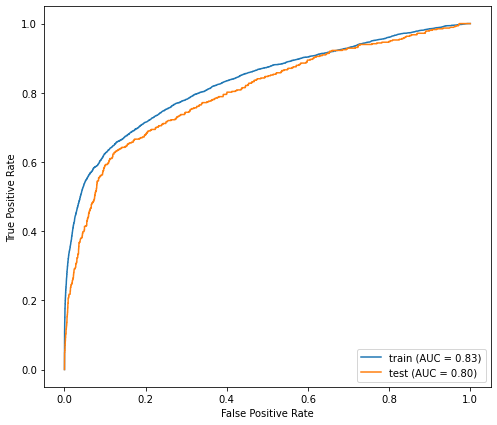

In [29]:
param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
}

gbc_cv = GradientBoostingClassifier(n_estimators=100,
                                    max_depth=5,
                                    max_features='auto', 
                                    random_state=random_state)

gbc_search = GridSearchCV(gbc_cv, 
                      param_grid, 
                      cv=cv_generator,
                      scoring='roc_auc',
                      return_train_score=True)

gbc_search.fit(X_train, y_train)

print(f"Best params: {gbc_search.best_params_}")

plot_metrics(gbc_search)


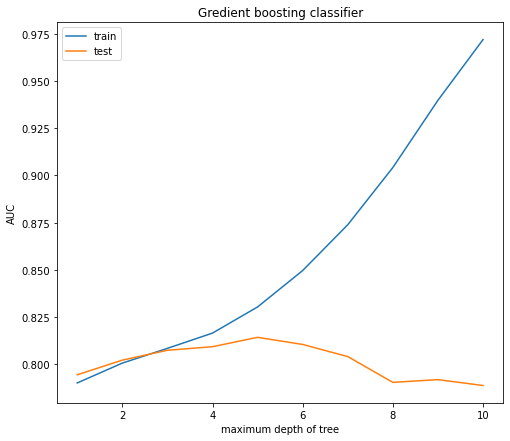

In [30]:
pd.DataFrame({"train":gbc_search.cv_results_["mean_train_score"], 
              "test":gbc_search.cv_results_["mean_test_score"]}, 
             index=[list(x.values())[0] for x in gbc_search.cv_results_["params"]]).plot(figsize=(8, 7))
plt.title("Gredient boosting classifier")
plt.xlabel("maximum depth of tree")
plt.ylabel("AUC")
plt.savefig("overfitting.jpg", bbox_inches='tight', dpi=150)


# Cat Boost

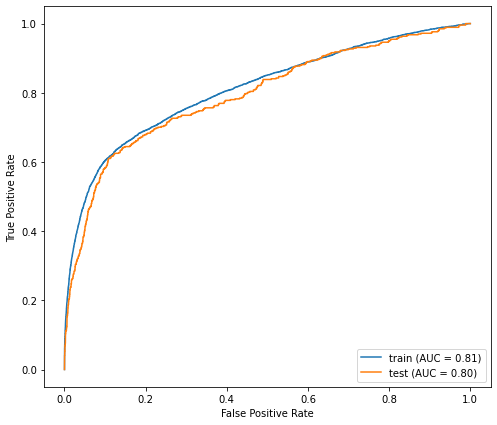

In [31]:
train_pool = Pool(data=X_train, label=y_train)

val_pool = Pool(data=X_test, label=y_test)

params = dict(learning_rate=0.1,
              random_seed=random_state,
              iterations=50,
              custom_loss=['AUC'],
              max_depth=7,
              loss_function='Logloss',
              early_stopping_rounds=20)

cbc = CatBoostClassifier(**params)

cbc.fit(train_pool, verbose=False, plot=False)

plot_metrics(cbc)


### Cross Validation - CBC

In [32]:
cbc_cv = CatBoostClassifier(**params)

cv_cbc = cross_validate(cbc_cv, 
                    X_train, 
                    y_train, 
                    cv=cv_generator, 
                    scoring={'roc_auc':'roc_auc', "f1":'f1'},
                    return_train_score=True,
                    return_estimator=True)


print("roc_auc")
print(f"\ttrainin: {np.mean(cv_cbc['train_roc_auc'])}")
print(f"\tvalidation: {np.mean(cv_cbc['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test, es.predict_proba(X_test)[:,1]) for es in cv_cbc['estimator']])}")


0:	learn: 0.5946133	total: 21.1ms	remaining: 1.03s
1:	learn: 0.5201759	total: 35.6ms	remaining: 853ms
2:	learn: 0.4668787	total: 48ms	remaining: 752ms
3:	learn: 0.4241777	total: 65ms	remaining: 748ms
4:	learn: 0.3920368	total: 81.4ms	remaining: 733ms
5:	learn: 0.3658478	total: 98ms	remaining: 719ms
6:	learn: 0.3464431	total: 113ms	remaining: 696ms
7:	learn: 0.3323718	total: 131ms	remaining: 688ms
8:	learn: 0.3202284	total: 148ms	remaining: 672ms
9:	learn: 0.3109424	total: 167ms	remaining: 666ms
10:	learn: 0.3045400	total: 182ms	remaining: 647ms
11:	learn: 0.2985141	total: 199ms	remaining: 630ms
12:	learn: 0.2934575	total: 215ms	remaining: 613ms
13:	learn: 0.2892332	total: 235ms	remaining: 603ms
14:	learn: 0.2861596	total: 250ms	remaining: 584ms
15:	learn: 0.2833839	total: 267ms	remaining: 566ms
16:	learn: 0.2813832	total: 287ms	remaining: 557ms
17:	learn: 0.2791750	total: 304ms	remaining: 541ms
18:	learn: 0.2782274	total: 321ms	remaining: 524ms
19:	learn: 0.2774383	total: 338ms	remaini

16:	learn: 0.2811433	total: 414ms	remaining: 804ms
17:	learn: 0.2793030	total: 439ms	remaining: 781ms
18:	learn: 0.2778604	total: 461ms	remaining: 753ms
19:	learn: 0.2765018	total: 482ms	remaining: 723ms
20:	learn: 0.2754342	total: 508ms	remaining: 701ms
21:	learn: 0.2747383	total: 526ms	remaining: 669ms
22:	learn: 0.2739783	total: 565ms	remaining: 664ms
23:	learn: 0.2733294	total: 589ms	remaining: 638ms
24:	learn: 0.2725212	total: 644ms	remaining: 644ms
25:	learn: 0.2719533	total: 667ms	remaining: 615ms
26:	learn: 0.2714491	total: 689ms	remaining: 587ms
27:	learn: 0.2707860	total: 724ms	remaining: 569ms
28:	learn: 0.2703604	total: 747ms	remaining: 541ms
29:	learn: 0.2699051	total: 767ms	remaining: 511ms
30:	learn: 0.2694854	total: 802ms	remaining: 492ms
31:	learn: 0.2691253	total: 826ms	remaining: 464ms
32:	learn: 0.2687254	total: 862ms	remaining: 444ms
33:	learn: 0.2683401	total: 884ms	remaining: 416ms
34:	learn: 0.2680694	total: 904ms	remaining: 387ms
35:	learn: 0.2677373	total: 927

In [33]:
print(classification_report(y_test, cbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3654
           1       0.68      0.22      0.33       464

    accuracy                           0.90      4118
   macro avg       0.79      0.60      0.64      4118
weighted avg       0.88      0.90      0.88      4118



### Final Results

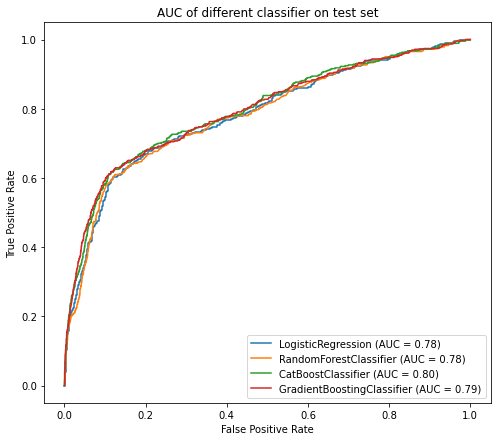

In [34]:
fig = plt.figure(figsize=(8, 7)).gca()
plot_roc_curve(lr, X_test, y_test, ax=fig)
plot_roc_curve(rfc, X_test, y_test, ax=fig)
plot_roc_curve(cbc, X_test, y_test, ax=fig)
plot_roc_curve(gbc, X_test, y_test, ax=fig)
plt.title("AUC of different classifier on test set")
plt.savefig("final.jpg", bbox_inches='tight', dpi=150)
plt.show()

# SMOTE

In [35]:
np.unique(y_train, return_counts=True) 

(array([0, 1]), array([32883,  4175], dtype=int64))

In [36]:
over_sample = SMOTE(sampling_strategy=0.3)
under_sample = RandomUnderSampler(sampling_strategy=0.4)

X_resample, y_resample = over_sample.fit_resample(X_train, y_train)
X_resample, y_resample = under_sample.fit_resample(X_resample, y_resample)


In [37]:
np.unique(y_resample, return_counts=True)

(array([0, 1]), array([24660,  9864], dtype=int64))

### Random Forest with SMOTE

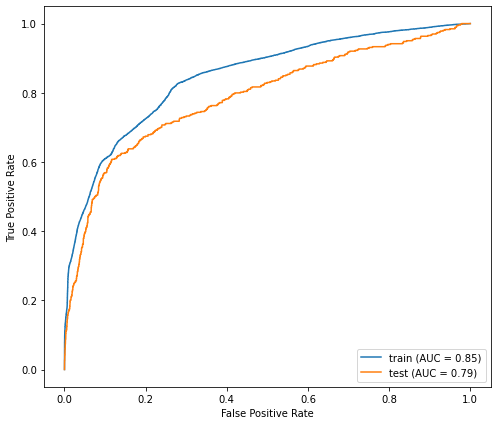

In [38]:
rfc_sample = RandomForestClassifier(class_weight='balanced_subsample',
                                    max_depth=5,
                                    random_state=random_state)

rfc_sample.fit(X_resample, y_resample)

plot_metrics(rfc_sample, X_train=X_resample, y_train=y_resample, X_test=X_test, y_test=y_test)


In [39]:
model = RandomForestClassifier(class_weight='balanced_subsample', max_depth=5, random_state=random_state)

# model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=random_state)

cv_generator = StratifiedShuffleSplit(n_splits=5, test_size=0.01, random_state=random_state)

cv = cross_validate(model,
                    X_resample,
                    y_resample,
                    cv=cv_generator,
                    scoring={'roc_auc': 'roc_auc', "f1": 'f1'},
                    return_estimator=True,
                    return_train_score=True)

print("roc_auc")
print(f"\tresample_trainin: {np.mean(cv['train_roc_auc'])}")
print(f"\tresample_validation: {np.mean(cv['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test, es.predict_proba(X_test)[:,1]) for es in cv['estimator']])}")


roc_auc
	resample_trainin: 0.8478334067310591
	resample_validation: 0.8514987936040568
	test: 0.7859473793480928


# Feature Pruning

In [40]:
data_prune = df.drop('y', axis=1)
label_prune  = df['y']

### Drop Correlated and Less Improtan Features

In [41]:
col_to_drop = ['euribor3m','job','marital','day_of_week','loan', 
               'housing','education','campaign','default','month','poutcome','previous',
               'contact', 
               'pdays', 
               'emp.var.rate']

data_prune = data_prune.drop(col_to_drop, axis=1)

### Train Test Split

In [42]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=random_state)
(train_indices_prune, test_indices_prune), (_, _)  = sss.split(data_prune, label_prune)
X_train_prune, y_train_prune = data_prune.iloc[data_prune.index[train_indices_prune]], label_prune[train_indices_prune]
X_test_prune, y_test_prune = data_prune.iloc[data_prune.index[test_indices_prune]], label_prune[test_indices_prune]

In [43]:
print(f'training data  size {X_train_prune.shape}')
print(f'testing data  size {X_test_prune.shape}')

training data  size (37058, 4)
testing data  size (4118, 4)


In [44]:
class_weight = pd.DataFrame({'y': y_train_prune})['y'].value_counts(normalize=True).to_dict()
print("classes distribution")
print(f"\ttraining: {class_weight}")
print(f"\ttesting: {pd.DataFrame({'y': y_test_prune})['y'].value_counts(normalize=True).to_dict()}")

classes distribution
	training: {'no': 0.8873387662582978, 'yes': 0.1126612337417022}
	testing: {'no': 0.8873239436619719, 'yes': 0.11267605633802817}


In [45]:
X_train_prune.head()

,age,cons.price.idx,cons.conf.idx,nr.employed
24602,50,93.200,-42.0,5195.8
23979,58,93.444,-36.1,5228.1
29348,36,93.075,-47.1,5099.1
5598,37,93.994,-36.4,5191.0
2083,38,93.994,-36.4,5191.0


### Label Encoder

In [46]:
label_enc = LabelEncoder()
y_train_prune = label_enc.fit_transform(y_train_prune)
y_test_prune = label_enc.transform(y_test_prune)


### Cross Valdiation Set Generator

In [47]:
cv_generator = StratifiedShuffleSplit(n_splits=5, 
                                      test_size=0.01, 
                                      random_state=random_state)


### Logistic Regresstion

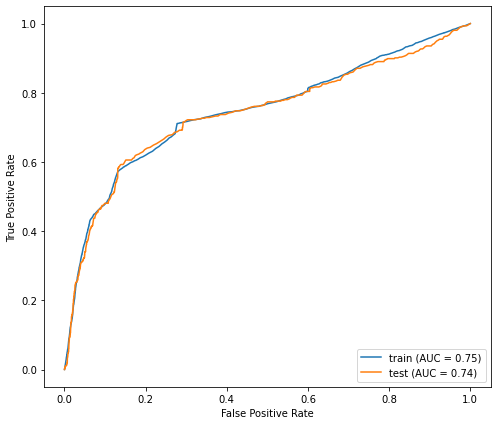

In [48]:
lr_prune = LogisticRegression(class_weight ='balanced', max_iter=1000)

lr_prune.fit(X_train_prune,y_train_prune)

plot_metrics(lr_prune, X_train=X_train_prune, y_train=y_train_prune, X_test=X_test_prune, y_test=y_test_prune)


###### Cross Validation - LR

In [49]:
lr_cv = LogisticRegression(class_weight ='balanced', max_iter=1000)

cv_lr = cross_validate(lr_cv, 
                    X_train_prune, y_train_prune, 
                    cv=cv_generator, 
                    scoring={'roc_auc':'roc_auc', "f1":'f1'},
                    return_train_score=True,
                    return_estimator=True
                   )


print("roc_auc")
print(f"\ttrainin: {np.mean(cv_lr['train_roc_auc'])}")
print(f"\tvalidation: {np.mean(cv_lr['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test_prune, es.predict_proba(X_test_prune)[:,1]) for es in cv_lr['estimator']])}")


roc_auc
	trainin: 0.746289362151362
	validation: 0.7595599942104501
	test: 0.7413528277938207


### Random Forest

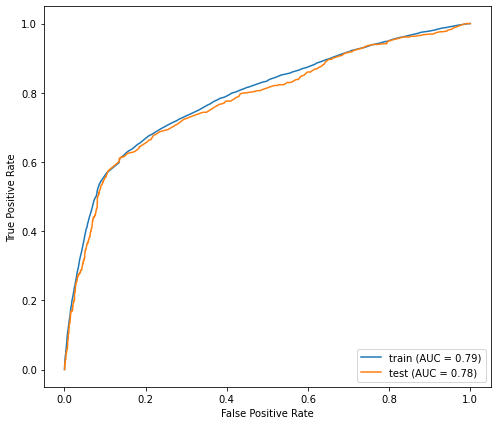

In [50]:
rfc_prune = RandomForestClassifier(class_weight ='balanced_subsample',
                            max_depth=5,
                            random_state=random_state)
rfc_prune.fit(X_train_prune,y_train_prune)

plot_metrics(rfc_prune, X_train=X_train_prune, y_train=y_train_prune, X_test=X_test_prune, y_test=y_test_prune)


<BarContainer object of 4 artists>

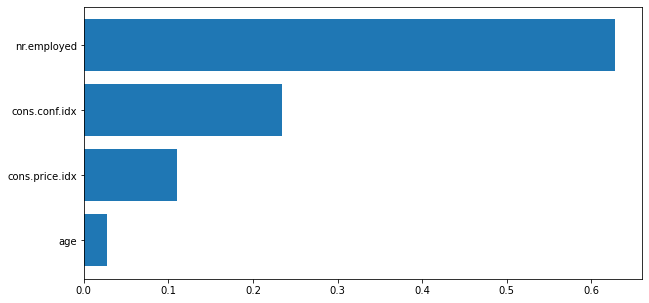

In [51]:
plt.figure(figsize=(10,5))
plt.barh(X_train_prune.columns, rfc_prune.feature_importances_)

###### Cross Validation - RFC

In [52]:
rfc_cv = RandomForestClassifier(class_weight ='balanced_subsample',
                                max_depth=5,
                                random_state=random_state)

cv_rfc = cross_validate(rfc_cv, 
                    X_train_prune, y_train_prune, 
                    cv=cv_generator, 
                    scoring={'roc_auc':'roc_auc', "f1":'f1'},
                    return_train_score=True,
                    return_estimator=True)


print("roc_auc")
print(f"\ttrainin: {np.mean(cv_rfc['train_roc_auc'])}")
print(f"\tvalidation: {np.mean(cv_rfc['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test_prune, es.predict_proba(X_test_prune)[:,1]) for es in cv_rfc['estimator']])}")


roc_auc
	trainin: 0.7902886426336595
	validation: 0.7872268056158634
	test: 0.7777351343827267


### Gradient Boosting Classifier

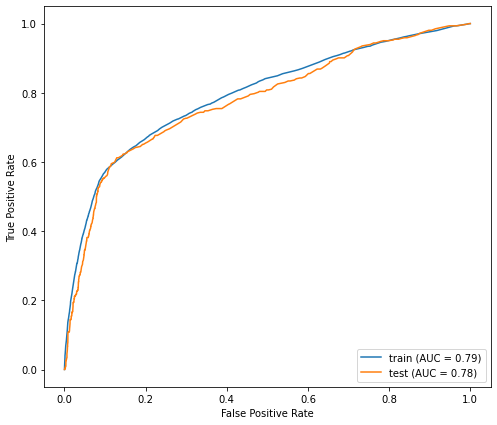

In [53]:
gbc_prune = GradientBoostingClassifier(n_estimators=100, max_depth=5, 
                                 random_state=random_state, n_iter_no_change=10, 
                                 subsample=0.5)

gbc_prune.fit(X_train_prune,y_train_prune)

plot_metrics(gbc_prune, X_train=X_train_prune, y_train=y_train_prune, X_test=X_test_prune, y_test=y_test_prune)


<BarContainer object of 4 artists>

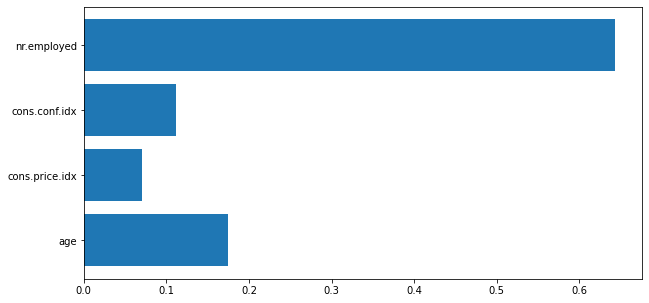

In [54]:
plt.figure(figsize=(10,5))
plt.barh(X_train_prune.columns, gbc_prune.feature_importances_)


###### Cross Validation - GBC

In [55]:
gbc_cv = GradientBoostingClassifier(n_estimators=100, max_depth=5, 
                                 random_state=random_state, n_iter_no_change=10, 
                                 subsample=0.5)

cv_gbc = cross_validate(gbc_cv, 
                    X_train_prune, y_train_prune,
                    cv=cv_generator, 
                    scoring={'roc_auc':'roc_auc', "f1":'f1'},
                    return_train_score=True,
                    return_estimator=True)


print("roc_auc")
print(f"\ttrainin: {np.mean(cv_gbc['train_roc_auc'])}")
print(f"\tvalidation: {np.mean(cv_gbc['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test_prune, es.predict_proba(X_test_prune)[:,1]) for es in cv_gbc['estimator']])}")


roc_auc
	trainin: 0.793459512138041
	validation: 0.7842451874366768
	test: 0.7778945015382294


### Cat Boost

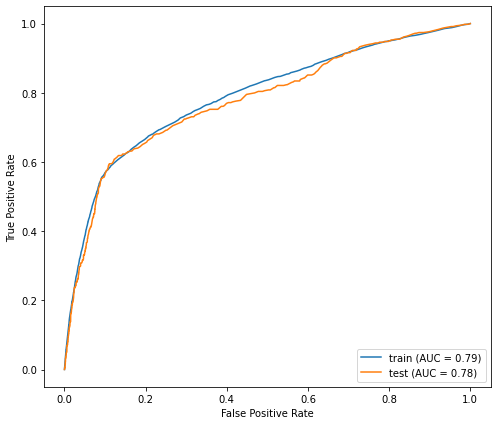

In [56]:
train_pool = Pool(data=X_train_prune, label=y_train_prune,)
al_pool = Pool(data=X_test_prune, label=y_test_prune)

params = dict(learning_rate=0.1, random_seed=0,
              iterations=50, custom_loss=['AUC'],
              max_depth=7, loss_function='Logloss', early_stopping_rounds=20)

cbc_prune = CatBoostClassifier(**params)

cbc_prune.fit(train_pool, verbose=False, plot=False)

plot_metrics(cbc_prune, X_train=X_train_prune, y_train=y_train_prune, X_test=X_test_prune, y_test=y_test_prune)


###### Cross Validation - CBC

In [57]:
cbc_cv = CatBoostClassifier(**params)

cv_cbc = cross_validate(cbc_cv, 
                    X_train_prune, y_train_prune, 
                    cv=cv_generator, 
                    scoring={'roc_auc':'roc_auc', "f1":'f1'},
                    return_train_score=True,
                    return_estimator=True)


print("roc_auc")
print(f"\ttrainin: {np.mean(cv_cbc['train_roc_auc'])}")
print(f"\tvalidation: {np.mean(cv_cbc['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test_prune, es.predict_proba(X_test_prune)[:,1]) for es in cv_cbc['estimator']])}")

0:	learn: 0.6299682	total: 6.71ms	remaining: 329ms
1:	learn: 0.5780929	total: 12.5ms	remaining: 301ms
2:	learn: 0.5349264	total: 17.3ms	remaining: 271ms
3:	learn: 0.4991481	total: 22.5ms	remaining: 259ms
4:	learn: 0.4685166	total: 29.3ms	remaining: 264ms
5:	learn: 0.4431522	total: 34ms	remaining: 250ms
6:	learn: 0.4209000	total: 39.8ms	remaining: 245ms
7:	learn: 0.4018283	total: 46.1ms	remaining: 242ms
8:	learn: 0.3854845	total: 51.7ms	remaining: 236ms
9:	learn: 0.3716932	total: 57.7ms	remaining: 231ms
10:	learn: 0.3594287	total: 63.8ms	remaining: 226ms
11:	learn: 0.3494056	total: 68.1ms	remaining: 216ms
12:	learn: 0.3402788	total: 73.9ms	remaining: 210ms
13:	learn: 0.3326127	total: 79.7ms	remaining: 205ms
14:	learn: 0.3258846	total: 85.6ms	remaining: 200ms
15:	learn: 0.3201929	total: 92.2ms	remaining: 196ms
16:	learn: 0.3152581	total: 98.2ms	remaining: 191ms
17:	learn: 0.3107165	total: 105ms	remaining: 186ms
18:	learn: 0.3069025	total: 111ms	remaining: 181ms
19:	learn: 0.3038353	total

28:	learn: 0.2877989	total: 189ms	remaining: 137ms
29:	learn: 0.2871047	total: 194ms	remaining: 129ms
30:	learn: 0.2862490	total: 201ms	remaining: 123ms
31:	learn: 0.2857481	total: 207ms	remaining: 116ms
32:	learn: 0.2853062	total: 214ms	remaining: 110ms
33:	learn: 0.2847456	total: 220ms	remaining: 104ms
34:	learn: 0.2843144	total: 227ms	remaining: 97.1ms
35:	learn: 0.2839472	total: 233ms	remaining: 90.7ms
36:	learn: 0.2836685	total: 240ms	remaining: 84.2ms
37:	learn: 0.2833700	total: 248ms	remaining: 78.2ms
38:	learn: 0.2830763	total: 254ms	remaining: 71.6ms
39:	learn: 0.2828866	total: 260ms	remaining: 65ms
40:	learn: 0.2826979	total: 267ms	remaining: 58.5ms
41:	learn: 0.2825922	total: 273ms	remaining: 51.9ms
42:	learn: 0.2824465	total: 280ms	remaining: 45.5ms
43:	learn: 0.2823423	total: 286ms	remaining: 39ms
44:	learn: 0.2821978	total: 292ms	remaining: 32.5ms
45:	learn: 0.2820815	total: 299ms	remaining: 26ms
46:	learn: 0.2819635	total: 306ms	remaining: 19.6ms
47:	learn: 0.2818623	tot

### Final Results

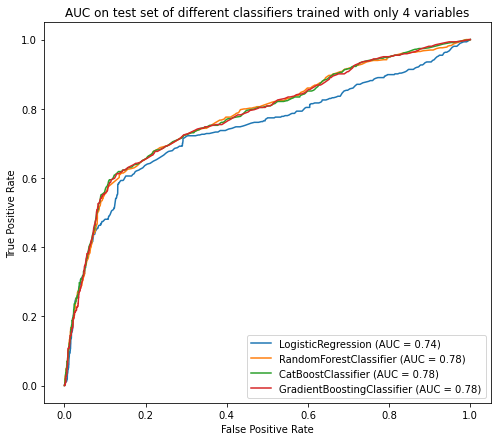

In [58]:
fig = plt.figure(figsize=(8,7)).gca()
plot_roc_curve(lr_prune, X_test_prune, y_test_prune, ax=fig)
plot_roc_curve(rfc_prune, X_test_prune, y_test_prune, ax=fig)
plot_roc_curve(cbc_prune, X_test_prune, y_test_prune, ax=fig)
plot_roc_curve(gbc_prune, X_test_prune, y_test_prune, ax=fig)
plt.title("AUC on test set of different classifiers trained with only 4 variables")
plt.savefig("feature pruning.jpg", bbox_inches='tight', dpi=150)

In [59]:
X_train_prune.columns

Index(['age', 'cons.price.idx', 'cons.conf.idx', 'nr.employed'], dtype='object')

# Probability Threshold Tuning

In [60]:
def plot_fpr_tpr(fpr, tpr, thresholds):
    plt.figure(figsize=(15, 10))
    plt.plot(fpr, thresholds, color='orange', label='fpr')
    plt.plot(tpr, thresholds, color='blue', label='trp')
    plt.xlabel('TPR/FPR')
    plt.ylabel('Threshold')
    plt.legend()
    plt.show()

def print_classification_report(classifier, pr=0.5, X_test=X_test, y_test=y_test):
    y_predicted = (classifier.predict_proba(X_test)[:,1]>pr).astype(int)
    print(classification_report(y_test, y_predicted))

### GBC

classification report for default prbability threshold
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3654
           1       0.54      0.19      0.28       464

    accuracy                           0.89      4118
   macro avg       0.72      0.59      0.61      4118
weighted avg       0.86      0.89      0.87      4118



 classification report for default prbability 0.1199489318075948
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      3654
           1       0.38      0.61      0.47       464

    accuracy                           0.84      4118
   macro avg       0.66      0.74      0.69      4118
weighted avg       0.88      0.84      0.86      4118



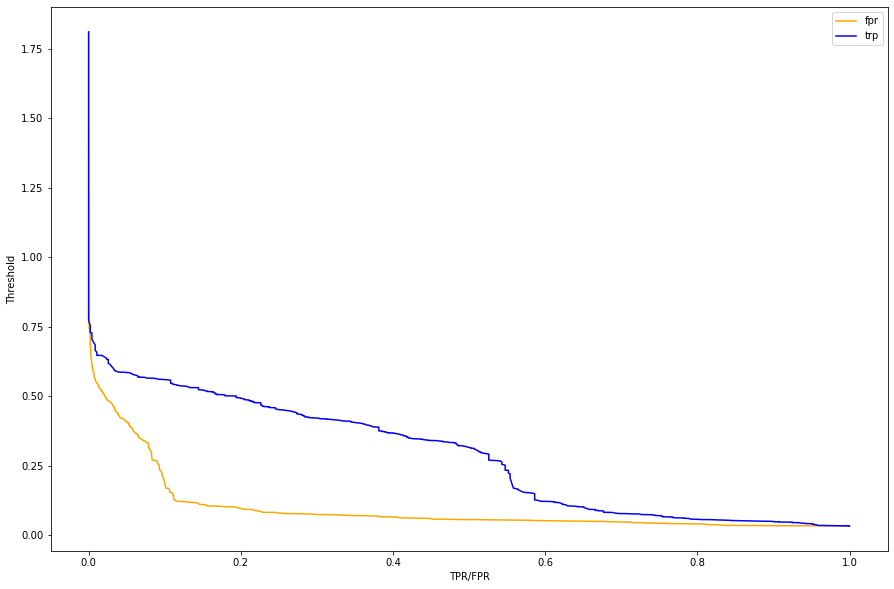

In [61]:
fpr, tpr, thresholds = roc_curve(y_test_prune, gbc_prune.predict_proba(X_test_prune)[:,1])

optimal_threshold = thresholds[np.argmax(tpr - fpr)]

print(f"classification report for default prbability threshold")
print_classification_report(gbc_prune, X_test=X_test_prune, y_test=y_test_prune)

print(f"\n\n classification report for default prbability {optimal_threshold}")
print_classification_report(gbc_prune, optimal_threshold, X_test=X_test_prune, y_test=y_test_prune)

plot_fpr_tpr(fpr, tpr, thresholds)

### CBC

classification report for default prbability threshold
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3654
           1       0.57      0.16      0.25       464

    accuracy                           0.89      4118
   macro avg       0.73      0.57      0.59      4118
weighted avg       0.86      0.89      0.86      4118



 classification report for default prbability 0.13059214202723957
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      3654
           1       0.38      0.61      0.47       464

    accuracy                           0.84      4118
   macro avg       0.66      0.74      0.69      4118
weighted avg       0.88      0.84      0.86      4118



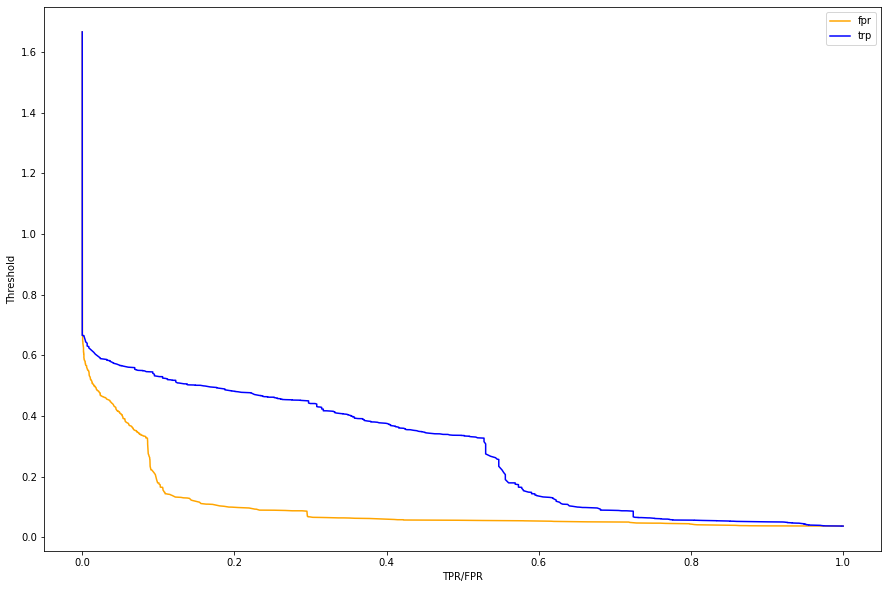

In [62]:
fpr, tpr, thresholds = roc_curve(y_test_prune, cbc_prune.predict_proba(X_test_prune)[:,1])

optimal_threshold = thresholds[np.argmax(tpr - fpr)]

print(f"classification report for default prbability threshold")
print_classification_report(cbc_prune, X_test=X_test_prune, y_test=y_test_prune)

print(f"\n\n classification report for default prbability {optimal_threshold}")
print_classification_report(cbc_prune, optimal_threshold, X_test=X_test_prune, y_test=y_test_prune)

plot_fpr_tpr(fpr, tpr, thresholds)

# Conclusion

In [63]:
def final_report(classifier, X_test=X_test, y_test=y_test):
    fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    optimal_threshold_idx = np.argmax(tpr - fpr)
    optimal_threshold, Optimal_tpr, Optimal_fpr = thresholds[optimal_threshold_idx], tpr[optimal_threshold_idx], fpr[optimal_threshold_idx]

    
    tn, fp, fn, tp = confusion_matrix(y_test, classifier.predict(X_test)).ravel()
    default_tpr = tp/(tp+fn)
    default_fpr = fp/(fp+tn)
    
    metric =  pd.DataFrame({'default':[default_tpr, default_fpr, 0.5], 
                            'tuned': [Optimal_tpr, Optimal_fpr, optimal_threshold]}, 
                           index=['tpr','fpr','threshold'])
    return metric
    


In [64]:
classifiers = [rfc, gbc, cbc]
classifiers_pruned = [rfc_prune, gbc_prune, cbc_prune]
names=['rf','gbc','cbc']
r = []
for name, clf, clf_prune in zip(names,classifiers, classifiers_pruned):
    

    result = final_report(clf)
    column_name = [(name,'default'),(name,'tuned')]
    result.columns=pd.MultiIndex.from_tuples(column_name)
    
    result_prune = final_report(clf_prune, X_test=X_test_prune, y_test=y_test_prune)
    column_name_prune = [(f'{name}_prune','default'),(f'{name}_prune','tuned')]
    result_prune.columns=pd.MultiIndex.from_tuples(column_name_prune)
    con = pd.concat([result, result_prune], axis=1)
    print(name)
    print(con)
    print('\n')
    con.to_excel(f'{name}.xlsx')

rf
                 rf            rf_prune          
            default     tuned   default     tuned
tpr        0.706897  0.609914  0.609914  0.614224
fpr        0.259168  0.124521  0.136836  0.139026
threshold  0.500000  0.574769  0.500000  0.477028


gbc
                gbc           gbc_prune          
            default     tuned   default     tuned
tpr        0.237069  0.618534  0.193966  0.612069
fpr        0.016694  0.114669  0.021346  0.128900
threshold  0.500000  0.119277  0.500000  0.119949


cbc
                cbc           cbc_prune          
            default     tuned   default     tuned
tpr        0.215517  0.609914  0.157328  0.618534
fpr        0.012863  0.108374  0.015326  0.133005
threshold  0.500000  0.145860  0.500000  0.130592


